# Seam Carving Performance Analysis - MPI Implementation
This notebook analyzes the performance of the MPI seam carving implementation across 50 images of different widths.
For each image, we remove 1/4 of its width and measure the execution time.

In [21]:
import os
import time
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Create output directory if it doesn't exist
os.makedirs("outputdata_temp", exist_ok=True)

In [22]:
def process_image(input_path, output_path, num_seams, num_processes):
    """Process a single image and return execution time"""
    try:
        start_time = time.time()
        
        # Run the seam carving executable
        cmd = ["mpiexec","-n", str(num_processes),"seam_carving_mpi.exe", input_path, output_path, str(num_seams)]
        subprocess.run(cmd, check=True)
        
        end_time = time.time()
        return end_time - start_time
    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        return None

In [27]:
def analyze_performance(input_dir, output_dir, num_runs=1):
    """Analyze performance across all images"""
    results = []
    
    # Get all pnm images from input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith('.pnm')]
    image_files.sort(key=lambda x: int(x.split('.')[0]))  # Sort by width
    
    total_images = len(image_files)

    print(f"Found {len(image_files)} images to process")
    
    for idx, image_file in enumerate(image_files):
        input_path = os.path.join(input_dir, image_file)
        
        # Get image width
        with open(input_path, 'r') as f:
            header = f.readline()
            width = int(f.readline().split()[0])
        
        num_seams = (width // 4) // 4 * 4  # Remove ~1/4 of width, rounded to multiple of 4
        
        # Determine number of processes based on image index
        num_processes = 1 if idx < 20 else 4
        
        # Process image multiple times
        times = []
        current_image = image_files.index(image_file) + 1
        for run in range(num_runs):
            output_path = os.path.join(output_dir, f"output_{image_file}")
            execution_time = process_image(input_path, output_path, num_seams, num_processes)
            if execution_time is not None:
                # Convert seconds to milliseconds
                execution_time_ms = execution_time * 1000
                times.append(execution_time_ms)
                print(f"Image ({current_image}/{total_images}) - Run {run+1}/{num_runs}: {image_file} - {execution_time_ms:.2f} ms")
        
        if times:
            avg_time = np.mean(times)
            std_time = np.std(times)
            
            results.append({
                'Image': image_file,
                'Width': width,
                'Num_Seams': num_seams,
                'Average Time (s)': avg_time / 1000, # Convert back to seconds for consistency
                'Std Dev (s)': std_time / 1000
            })
    
    return results

In [28]:
# Run the analysis
input_dir = "inputdata_temp"
output_dir = "outputdata_temp"
results = analyze_performance(input_dir, output_dir)

# Print summary
print("\nPerformance Summary:")
print(f"Total images processed: {len(results)}")
print(f"Average processing time: {np.mean([r['Average Time (s)'] for r in results]):.2f} seconds")
print(f"Total processing time: {np.sum([r['Average Time (s)'] for r in results]):.2f} seconds")

Found 50 images to process
Image (1/50) - Run 1/1: 100.pnm - 65.85 ms
Image (2/50) - Run 1/1: 200.pnm - 107.25 ms
Image (3/50) - Run 1/1: 300.pnm - 229.02 ms
Image (4/50) - Run 1/1: 320.pnm - 288.81 ms
Image (5/50) - Run 1/1: 340.pnm - 340.89 ms
Image (6/50) - Run 1/1: 400.pnm - 442.38 ms
Image (7/50) - Run 1/1: 404.pnm - 483.55 ms
Image (8/50) - Run 1/1: 440.pnm - 578.89 ms
Image (9/50) - Run 1/1: 480.pnm - 604.44 ms
Image (10/50) - Run 1/1: 500.pnm - 807.38 ms
Image (11/50) - Run 1/1: 504.pnm - 855.73 ms
Image (12/50) - Run 1/1: 512.pnm - 936.93 ms
Image (13/50) - Run 1/1: 520.pnm - 863.74 ms
Image (14/50) - Run 1/1: 540.pnm - 962.70 ms
Image (15/50) - Run 1/1: 580.pnm - 1205.62 ms
Image (16/50) - Run 1/1: 600.pnm - 1244.97 ms
Image (17/50) - Run 1/1: 604.pnm - 1297.39 ms
Image (18/50) - Run 1/1: 606.pnm - 1276.03 ms
Image (19/50) - Run 1/1: 608.pnm - 1317.79 ms
Image (20/50) - Run 1/1: 620.pnm - 1374.75 ms
Image (21/50) - Run 1/1: 640.pnm - 743.00 ms
Image (22/50) - Run 1/1: 654.pnm

In [20]:
# Save results to JSON file
import json

with open('result_json/mpi_results.json', 'w') as f:
    json.dump(results, f, indent=4)


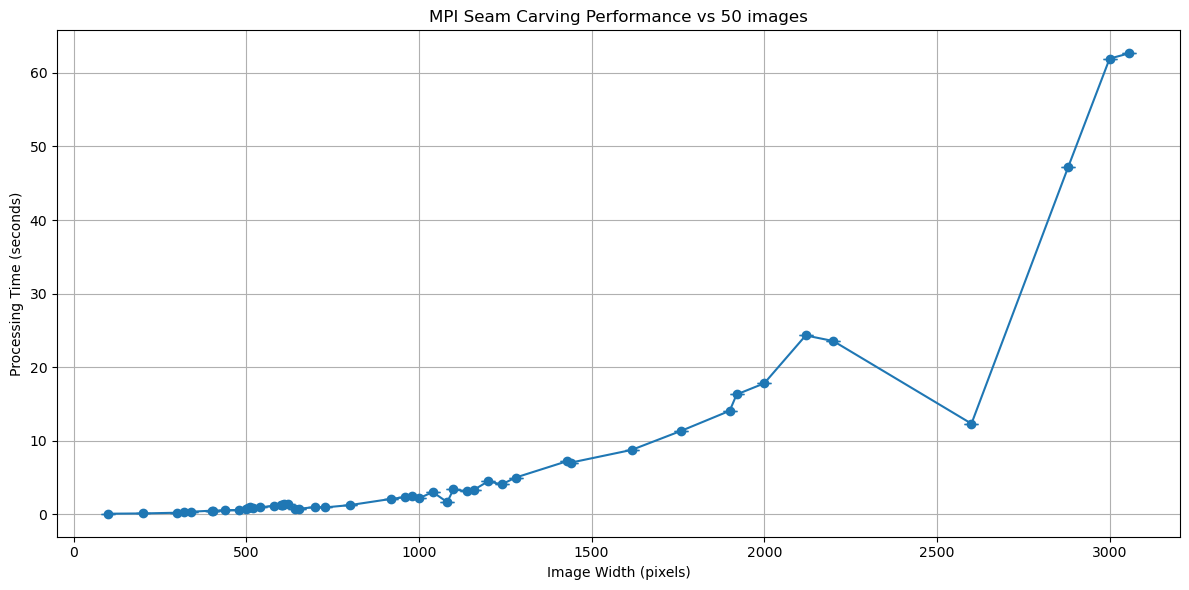

In [19]:
# Plot execution time vs image width
plt.figure(figsize=(12, 6))

widths = [r['Width'] for r in results]
times = [r['Average Time (s)'] for r in results]
errors = [r['Std Dev (s)'] for r in results]

plt.errorbar(widths, times, yerr=errors, fmt='o-', capsize=5)
plt.title('MPI Seam Carving Performance vs 50 images')
plt.xlabel('Image with different sizes')
plt.ylabel('Processing Time (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()